In [11]:
import datetime
import gc
import numpy as np
import os
import random
from scipy import misc
import string
import time
import sys
import sklearn.metrics as skm
import collections
from sklearn.svm import SVC
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
from sklearn import metrics
import dwdii_bc_model_helper as bc

random.seed(20275)
np.set_printoptions(precision=2)

In [12]:
imagePath = "png"
#imagePath = "/root/bc_data/Data_Thresholded/DDSM"
trainImagePath = imagePath
trainDataPath = "data/ddsm_train.csv"
testDataPath = "data/ddsm_test.csv"
categories = bc.bcNormVsAbnormNumerics()
imgResize = (150, 150)

In [13]:
os.listdir('data')

['ddsm_test.csv', 'ddsm_train.csv', 'ddsm_val.csv', 'mias_all.csv']

In [14]:
metaData, meta2, mCounts = bc.load_training_metadata(trainDataPath, balanceViaRemoval=True, verbose=True, 
                                                     normalVsAbnormal=True)

Raw Balance
----------------
abnormal 1270
normal 2685
balanaceViaRemoval.avgE: 1977
balanaceViaRemoval.theshold: 1977.0

After Balancing
----------------
abnormal 1270
normal 1623


In [15]:
# Actually load some representative data for model experimentation
maxData = len(metaData)
X_data, Y_data = bc.load_data(trainDataPath, trainImagePath, 
                              categories=categories,
                              maxData = maxData, 
                              verboseFreq = 50, 
                              imgResize=imgResize, 
                              normalVsAbnormal=True)
print X_data.shape
print Y_data.shape

Raw Balance
----------------
abnormal 1270
normal 2685
balanaceViaRemoval.avgE: 1977
balanaceViaRemoval.theshold: 1977.0

After Balancing
----------------
abnormal 1270
normal 1623


dwdii_bc_model_helper.py:194: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  X_data = np.zeros([total, x, y])
dwdii_bc_model_helper.py:195: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_data = np.zeros([total, 1], dtype=np.int8)


0.0000: A_0152_1.RIGHT_MLO.LJPEG.png
0.0173: C_0183_1.LEFT_MLO.LJPEG.png
0.0346: B_3073_1.RIGHT_MLO.LJPEG.png
0.0518: C_0010_1.RIGHT_MLO.LJPEG.png
0.0691: A_0609_1.RIGHT_MLO.LJPEG.png
0.0864: B_3426_1.RIGHT_MLO.LJPEG.png
0.1037: A_0079_1.RIGHT_MLO.LJPEG.png
0.1210: B_3122_1.LEFT_MLO.LJPEG.png
0.1383: C_0108_1.LEFT_MLO.LJPEG.png
0.1555: C_0222_1.RIGHT_CC.LJPEG.png
0.1728: C_0342_1.RIGHT_CC.LJPEG.png
0.1901: A_0048_1.LEFT_CC.LJPEG.png
0.2074: B_3067_1.RIGHT_MLO.LJPEG.png
0.2247: A_0255_1.LEFT_CC.LJPEG.png
0.2420: B_3077_1.RIGHT_MLO.LJPEG.png
0.2592: B_3621_1.LEFT_MLO.LJPEG.png
0.2765: C_0046_1.RIGHT_MLO.LJPEG.png
0.2938: A_0510_1.RIGHT_CC.LJPEG.png
0.3111: B_3412_1.LEFT_MLO.LJPEG.png
0.3284: B_3600_1.RIGHT_CC.LJPEG.png
0.3457: A_0027_1.RIGHT_MLO.LJPEG.png
0.3629: C_0466_1.LEFT_CC.LJPEG.png
0.3802: A_0367_1.RIGHT_MLO.LJPEG.png
0.3975: A_0441_1.RIGHT_CC.LJPEG.png
0.4148: B_3440_1.RIGHT_CC.LJPEG.png
0.4321: C_0392_1.RIGHT_MLO.LJPEG.png
0.4494: A_0202_1.RIGHT_MLO.LJPEG.png
0.4666: A_0390_1.L

In [16]:
# Actually load some representative data for model experimentation
maxData = len(metaData)
X_test, Y_test = bc.load_data(testDataPath, imagePath, 
                              categories=categories,
                              maxData = maxData, 
                              verboseFreq = 50, 
                              imgResize=imgResize, 
                              normalVsAbnormal=True)
print X_test.shape
print Y_test.shape

Raw Balance
----------------
abnormal 321
normal 658
balanaceViaRemoval.avgE: 489
balanaceViaRemoval.theshold: 489.0

After Balancing
----------------
abnormal 321
normal 405
0.0000: B_3380_1.RIGHT_MLO.LJPEG.png
0.0173: C_0082_1.LEFT_CC.LJPEG.png
0.0346: A_0359_1.LEFT_CC.LJPEG.png
0.0518: B_3092_1.LEFT_MLO.LJPEG.png
0.0691: B_3664_1.LEFT_MLO.LJPEG.png
0.0864: A_0070_1.LEFT_CC.LJPEG.png
0.1037: A_0567_1.RIGHT_MLO.LJPEG.png
0.1210: A_0343_1.LEFT_MLO.LJPEG.png
0.1383: A_1019_1.LEFT_MLO.LJPEG.png
0.1555: B_3681_1.RIGHT_CC.LJPEG.png
0.1728: A_1058_1.RIGHT_MLO.LJPEG.png
0.1901: A_0135_1.RIGHT_MLO.LJPEG.png
0.2074: B_3632_1.RIGHT_MLO.LJPEG.png
0.2247: A_0116_1.RIGHT_CC.LJPEG.png
0.2420: B_3039_1.LEFT_MLO.LJPEG.png
(726L, 150L, 150L)
(726L, 1L)


In [17]:
X_train = X_data
Y_train = Y_data

In [18]:
print X_train.shape
print X_test.shape

print Y_train.shape
print Y_test.shape

(2893L, 150L, 150L)
(726L, 150L, 150L)
(2893L, 1L)
(726L, 1L)


In [19]:
def yDist(y):
    bcCounts = collections.defaultdict(int)
    for a in range(0, y.shape[0]):
        bcCounts[y[a][0]] += 1
    return bcCounts

print "Y_train Dist: " + str(yDist(Y_train))
print "Y_test Dist: " + str(yDist(Y_test))

Y_train Dist: defaultdict(<type 'int'>, {0: 1623, 1: 1270})
Y_test Dist: defaultdict(<type 'int'>, {0: 405, 1: 321})


In [20]:
# Load the bc array for our count in the model definition
bcTypes = bc.bcNumerics()
print bcTypes
print len(bcTypes)

{'benign': 1, 'malignant': 2, 'normal': 0}
3


In [22]:
X_train_s = X_train.reshape((2893,-1))

In [23]:
X_test_s = X_test.reshape((726,-1))

In [24]:
model = SVC(gamma=0.001)

In [25]:
model.fit(X_train_s,Y_train)

C:\Anaconda2\lib\site-packages\sklearn\svm\base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
predicted = model.predict(X_test_s)
expected = Y_test

In [27]:
svm_matrix = skm.confusion_matrix(Y_test, predicted)
svm_matrix

array([[228, 177],
       [ 68, 253]])

In [28]:
print metrics.accuracy_score(expected,predicted)

0.662534435262


In [30]:
numBC = bc.reverseDict(categories)

In [31]:
class_names = numBC.values()
np.set_printoptions(precision=2)

In [33]:
# Plot non-normalized confusion matrix
plt.figure()
bc.plot_confusion_matrix(svm_matrix, classes=class_names,
                      title='Confusion matrix, without normalization, \n')
plt.savefig('cm_o_norm.png')

Confusion matrix, without normalization
[[228 177]
 [ 68 253]]


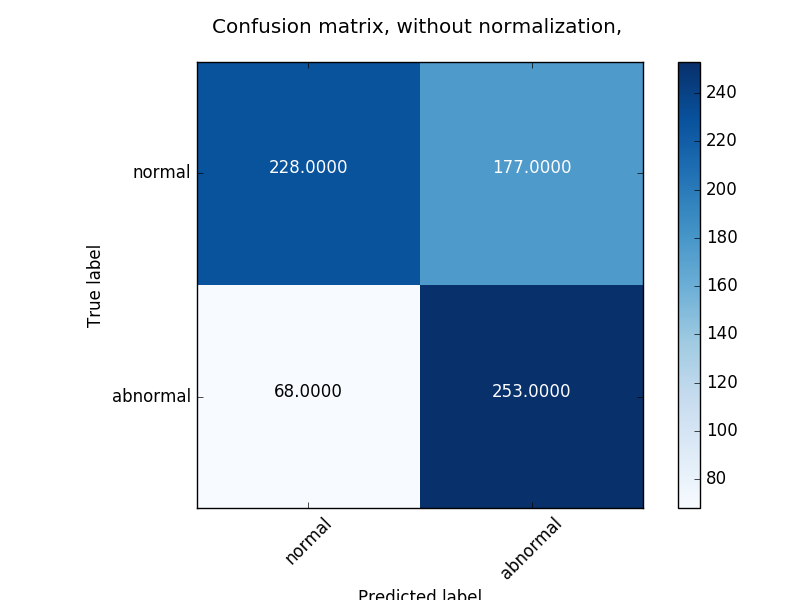

In [34]:
from IPython.display import Image
Image(filename='cm_o_norm.png')

In [36]:
plt.figure()
bc.plot_confusion_matrix(svm_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix \n')
plt.savefig('cm_norm.png')

Normalized confusion matrix
[[ 0.56  0.44]
 [ 0.21  0.79]]


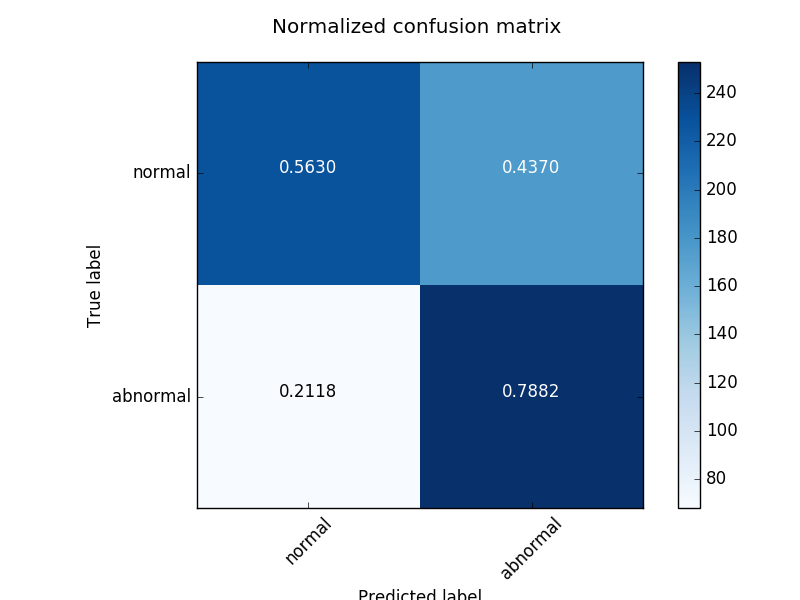

In [37]:
# Load the image we just saved
from IPython.display import Image
Image(filename='cm_norm.png')